# EXERCISE 13 - Supernovae distances and redshifts

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$\mu = m - M = 5\log_{10}(\frac{d_L}{pc}) - 5$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

## IMPORT MODULES

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit
from sklearn.linear_model import LinearRegression as skLR

import astroML.stats as astroMLstats

from astroML.datasets import generate_mu_z

In [2]:
from astroML.linear_model import LinearRegression

/home/studente/software/anaconda3/envs/pitone/lib/python3.9/site-packages/theano/scalar/basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

# L17:

## Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

### OPTIONAL

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

# 1 - FIT

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [14]:
# Data set-up

X = z_sample.copy()
X = X[:, None]

y = mu_sample.copy()
dy = dmu.copy()

z_range = [0, 2] # [z_sample.min(), z_sample.max()]
X_pred = np.linspace(z_range[0], z_range[1])[:, None]

## Linear Regression

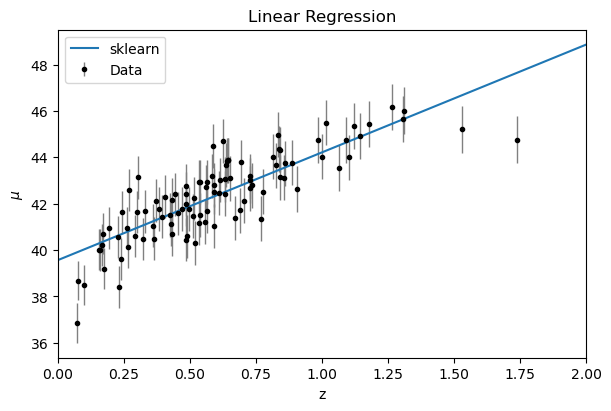

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

lr = skLR()
lr.fit(X, y)
y_pred = lr.predict(X_pred)

ax.plot(X_pred, y_pred, label='sklearn')

#lr = LinearRegression()
lr.fit(X, y, dy)
y_pred = lr.predict(X_pred)

#ax.plot(X_pred, y_pred, label='astroML')

ax.set_xlim(0, 2)

ax.set_title('Linear Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

## Polinomial Regression

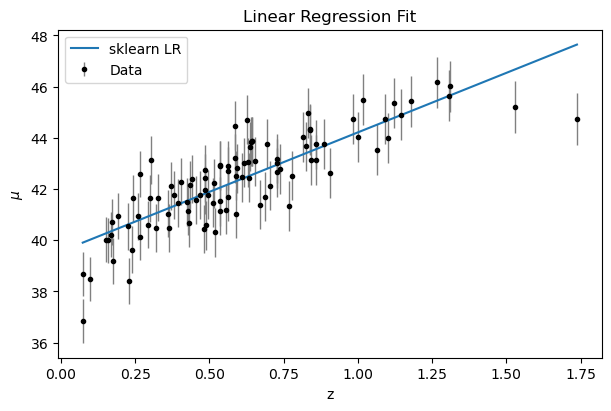

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

degree = [2, 3, 4, 5, 10, 15]

for n in degree:
    pr = PolinomialRegression(n)
    pr.fit(X, y, dy)
    y_pred = pr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'n = {n}')

ax.set_title('Polinomial Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

## Basis Function Regression

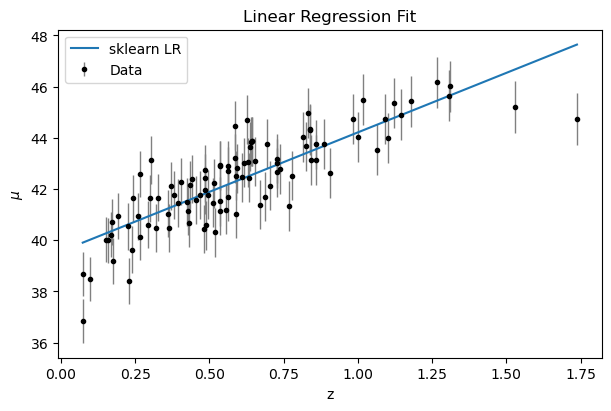

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

gaussian = [2, 3, 4, 5, 10, 15]

for n in gaussian:
    m = np.linspace(z_range[0], z_range[1], n)
    s = m[1] - m[0]
    
    bfr = BasisFunctionRegression('gaussian', mu=m, sigma=s)
    bfr.fit(X, y, dy)
    y_pred = bfr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'n = {n}')

ax.set_title('Basis Function (gaussian) Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

## Kernel Regression (Nadaraya-Waston)

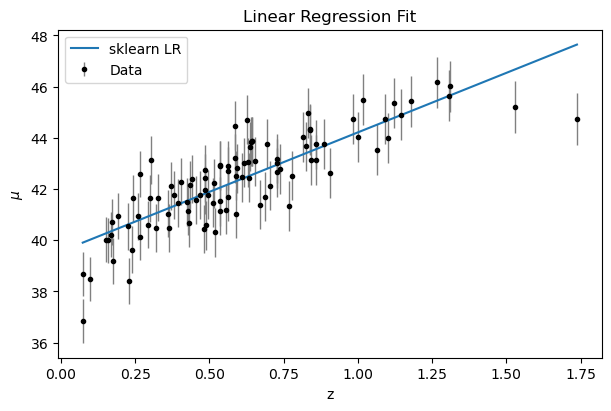

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

bandwidth = np.round(np.linspace(.01, .2, 6), 2)

for bw in bandwidth:
    kr = NadarayaWatson('gaussian', bw)
    kr.fit(X, y, dy) # NOTE: here dy is irrelevant
    y_pred = kr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'Bandwidth = {bw}')

ax.set_title('Basis Function (gaussian) Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

# 2 - CROSS VALIDATION

In [46]:
## --- FUNCTIONS --- ##

def rms_err(x_obs, x_exp):
    return np.sqrt(np.sum((x_obs - x_exp)**2) / len(x_obs))

def cv_err(X, y, dy, regressor, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=10)

    trn_err, tst_err = np.empty(K), np.empty(K)
    for i, index in enumerate(kf.split(X)):
        regressor.fit(X[index[0]], y[index[0]], dy[index[0]])

        trn_err[i] = rms_err(y[index[0]], regressor.predict(X[index[0]]))
        tst_err[i] = rms_err(y[index[1]], regressor.predict(X[index[1]]))

    return trn_err, tst_err

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


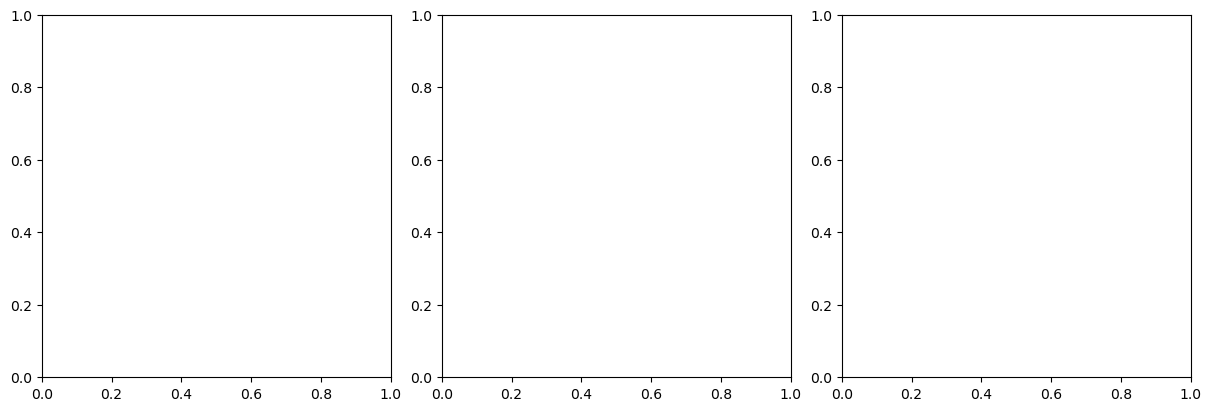

In [44]:
fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(12, 4), layout='constrained')

degree, gaussian, bandwidth = np.arange(20) + 1, np.arange(20) + 1, np.linspace(.01, .2, 25)

# -- Polinomial Regression

for n in degree:
    trn_err, tst_err = cv_err(X, y, dy, PolinomialRegression(n))
    ax.errorbar(n, np.median(trn_err), astroMLstats.sigmaG(trn_err), label='Train set')
    ax.errorbar(n, np.median(tst_err), astroMLstats.sigmaG(tst_err), label='Test set')

ax.set_title('Polinomial Regression CV')
ax.set_xlabel('Degree')
ax.set_ylabel('rms')
ax.legend()

# -- Basis Function Regression

for n in gaussian:
    m = np.linspace(z_range[0], z_range[1], n)
    s = m[1] - m[0]
    
    trn_err, tst_err = cv_err(X, y, dy, BasisFunctionRegression('gaussian', mu=m, sigma=s))
    bx.errorbar(n, np.median(trn_err), astroMLstats.sigmaG(trn_err), label='Train set')
    bx.errorbar(n, np.median(tst_err), astroMLstats.sigmaG(tst_err), label='Test set')

bx.set_title('Basis Function Regression CV')
bx.set_xlabel('Number of gaussians')
bx.set_ylabel('rms')
bx.legend()

# -- Kernel Regression (Nadaraya-Waston)

for bw in bandwidth:
    trn_err, tst_err = cv_err(X, y, dy, NadarayaWatson('gaussian', bw))
    cx.errorbar(n, np.median(trn_err), astroMLstats.sigmaG(trn_err), label='Train set')
    cx.errorbar(n, np.median(tst_err), astroMLstats.sigmaG(tst_err), label='Test set')

cx.set_title('Kernel Regression CV')
cx.set_xlabel('Bandwidth')
cx.set_ylabel('rms')
cx.legend()

# 3 - LEARNING CURVES

In [ ]:

common_params = {
    "X": z_sample,
    "y": mu_sample,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
}

In [ ]:
# see learning_curve/ShuffleSplit documentation

model = LinearRegression()
train_size, train_score, test_score = learning_curve(model, **common_params)

plt.plot(train_size, -test_score.mean(axis=1), 'o-', color="r", label="Val")
plt.plot(train_size, -train_score.mean(axis=1), 'o-', color="g", label="Train")

plt.xlabel('Number of training data points')

plt.legend()

In [ ]:
test_score.shape

# L18: